In [ ]:
import snntorch as snn
import sys
import platform
import torch
import pandas as pd
import sklearn as sk
import numpy as np

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

In [2]:
#Training Parameters 
batch_size = 128 
data_path = "data/mnist"
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

In [ ]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

In [4]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# Rate Coding

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true" width="500" height="300">

- each normalized input feature of MNIST image $X_{ij}$ is used as the probability an event (spike) occurs at any given time step returing a rate-coded value $R_{ij}$ 
- can be treated as a Bernoulli trial (binomial probability distribution): $R_{ij} ~ B(n,p)$, where the # of trials is n = 1 and the probability of success (spiking) is $p = X_{ij}$

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*URLjU8geccnWQatuZQzC8Q.png" width="500" height="300">

- *Explicitly, the probability a spike occurs is:*
$$P(R_{ij} = 1) = X_{ij} = 1-P(R_{ij} = 0)$$

In [18]:
# Temporal Dynamics 
num_steps = 10

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5 # vector of size 10

# pass each sample through a bernoulli trial 
rate_coded_vector = torch.bernoulli(raw_vector) # basically samples binomial distribution for each feature and returns 1 or 0 

print(f"Converted vector: {rate_coded_vector}")
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([1., 1., 0., 0., 0., 1., 0., 0., 1., 1.])
The output is spiking 50.00% of the time.


In [39]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")


The output is spiking 38.00% of the time.


As `num_steps` approaches -> $\infty$, the probability of a spike occurring approaches the original raw probabilities in $X$. 

- for MNIST image, proba of spiking corresponds to pixel value
    - white pixel = 100% proba of spiking 
    - black pixel = 0% proba of spiking

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true" width="600" height="300">

In a similar way, `spikegen.rate` can be used to generate a rate-coded sample of data. As each sample of MNIST is just an image, we can use `num_steps` to repeat it across time.




In [40]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data) # returns n samples where n = batch size

print(data_it.shape)
print(targets_it.shape)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)
print(spike_data.size()) #The structure of the input data is [num_steps x batch_size x input dimensions]

torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([100, 128, 1, 28, 28])


## viz with spikeplot

In [29]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

from IPython.display import HTML

In [41]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())


torch.Size([100, 28, 28])


In [48]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
plt.rcParams['animation.ffmpeg_path'] = '/Users/anushmutyala/opt/miniconda3/envs/torch/bin/ffmpeg'
plt.close()

HTML(anim.to_html5_video())


In [43]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 8


Modulating gain argument to reduce spiking frequency to 25% -> becomes more sparse in time 

In [49]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)

plt.close()
HTML(anim.to_html5_video())

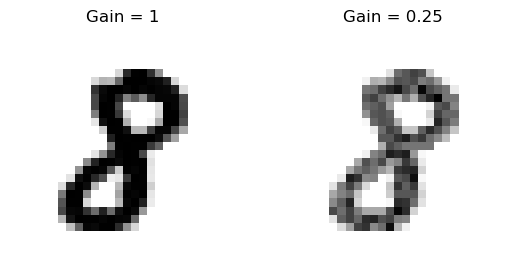

In [50]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

**raster plot =>  visually examine the trial-by-trial variability of the neural responses** 

The 28*28 spiking array is flattened and each index represents a single neuron -> 784 neurons in total.

reshape sample into 2D tensor with time as 1st dimension and let `spikeplot.raster` handle the rest



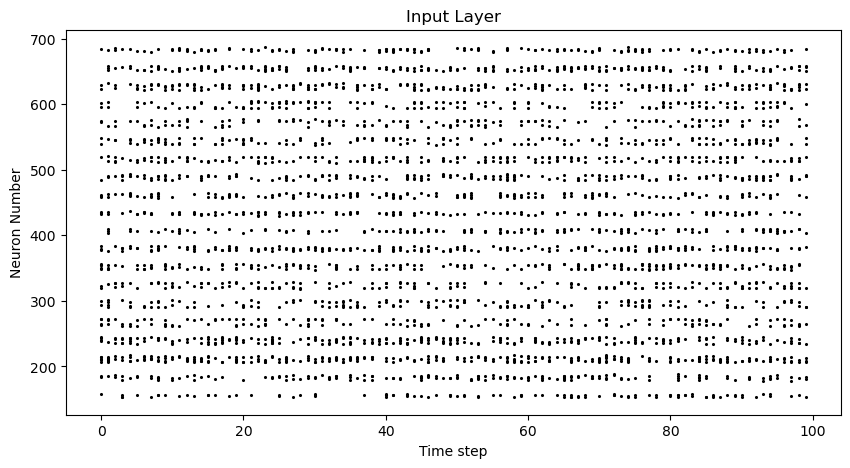

In [51]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

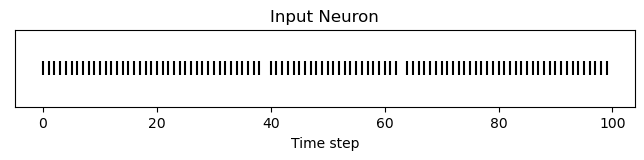

In [54]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

## Summary of Rate Coding Notes
The idea of rate coding being the primary spike encoding mechanism is controversial for a few reasons:
1. **power consumption**: rate-coding at most can only explain the activity of 15% of neurons in the primary visual cortex -> unlikely to be the only encoding mechanism within the resource-constrained brain
2. **reaction response times**: reaction time is ~250ms -> if avg firing rate of a neuron is ~10Hz, we can only process about 2 spikes within reaction timescale 

Although the brain may not process data as a rate, our sensory organs do because of the noise robustness vs. power/latency tradeoff -> it’s fine if some of the spikes fail to generate, because there will be plenty more where they came from 

In some cases where training SNNs proves to be challenging, encouraging more firing via a rate code is one possible solution based on Hebbian learning principle. 

# Latency Coding

- temporal codes capture info about firing time of neurons; a single spike carries more meaning than in rate codes which rely on firing frequency 
- increased susceptibility to noise but also decreases power consumption by orders of magnitude 

Prerequisite reading: [RC Circuit and Current Injection](https://neurotext.library.stonybrook.edu/C3/C3_3/C3_3.html)

- **RC circuit**: a circuit consisting of a resistor and a capacitor in series or parallel. The capacitor is charged by a current source and the voltage across the capacitor is measured. The voltage across the capacitor is proportional to the charge on the capacitor. The time constant of the circuit is the time it takes for the voltage across the capacitor to reach 63.2% of its final value. The time constant is given by the product of the resistance and capacitance of the circuit.
- Membrane capacitance can be used as a constraint on the speed of electrical communication between neurons by acting as a low-pass filter. Membrance capacitance, which can be modelled with RC circuits, sets minimum duration for current signals between cells. This is where the concept of time-encoding comes from. 
- more notes -> [here](/snn-neuronic/snnTorch_tutorials/SNN_Theory.pdf)

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_4_latencyrc.png?raw=true" width="500" heigh="500">

- Spike timing is calculated by treating the input feature as the current injection $I_{in}$ into an RC circuit.
- current moves to charge capacitor which increases voltage $V_{T}$ until it reaches a threshold $V_{thr}$ -> this results in spike generation

*for a given input (and equivalent input feature) $I_{in}$, the time it takes for the voltage to reach threshold $V_{thr}$ is the latency of the spike*

`spikegen.latency` is a function that allows each input to fire at most once during the full time sweep. Features closer to `1` will fire earlier and features closer to `0` will fire later. I.e., in our MNIST case, bright pixels will fire earlier and dark pixels will fire later.

*big input means fast spike; small input means late spike*

The following function uses the above result to convert a feature of intensity $X_{ij} \epsilon [0, 1] $ to a latency-coded value $L_{ij}$:

In [55]:
def convert_to_time(data, tau=5, threshold=0.01):
    spike_time = tau * torch.log(data / (data - threshold))
    return spike_time 

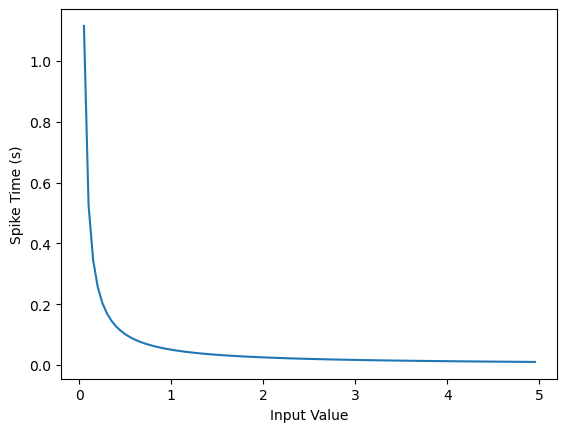

In [56]:
# input feature intensity vs. spike time 

raw_input = torch.arange(0, 5, 0.05)
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

*The smaller the value, the later the spike occurs with exponential dependence*

The vector `spike_times` contains the time at which sikes are triggered, rather than a sparse tensor that contains the spikes themselves (1s and 0s). When running an SNN simulation, a 1/0 representation is needed to obtain all the advantages of using spikes. `spikegen.latency` abstracts away this process.


In [58]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)
# tau = RC time constant, higher tau induces slower firing
# threshold = membrane potential firing threshold -> all inputs below this value are clipped and assigned to the final time step
spike_data.size()

torch.Size([100, 128, 1, 28, 28])

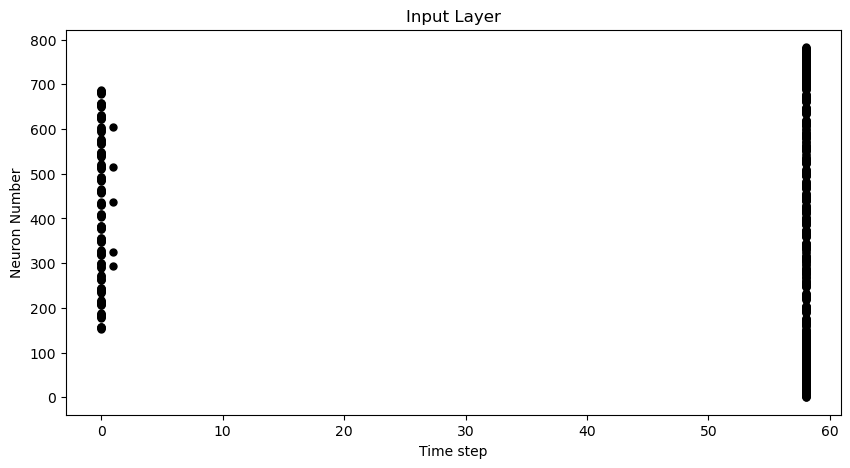

In [59]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()


<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_5_latencyraster.png?raw=true">

The logarithmic code coupled with the lack of diverse input values (i.e., the lack of midtone/grayscale features) causes significant clustering in two areas of the plot. The bright pixels induce firing at the start of the run, and the dark pixels at the end. We can increase `tau` to slow down the spike times, or linearize the spike times by setting the optional argument `linear=True`.

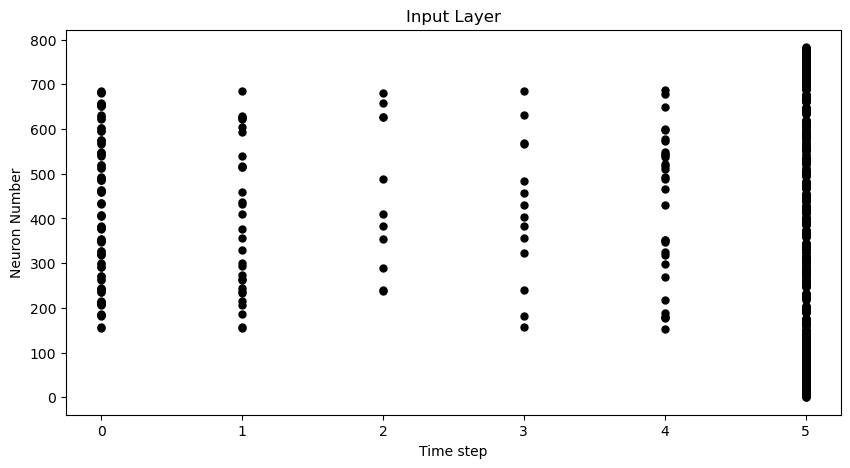

In [60]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

The linear model has no physical basis, it is purely a simplification of the biological model approximated by the RC circuit. 

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_6_latencylinear.png?raw=true" width="550" height="300">




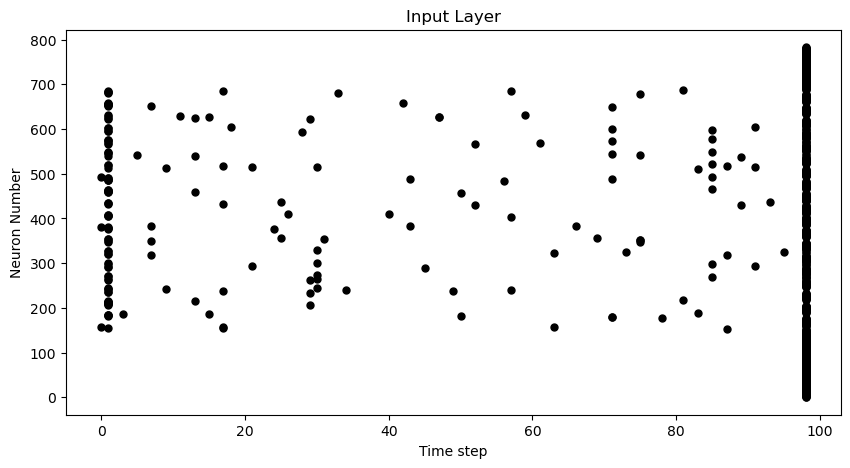

In [61]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

One major advantage of latency coding over rate coding is sparsity. If neurons are constrained to firing a maximum of once over the time course of interest, then this promotes low-power operation.

In the scenario shown above, a majority of the spikes occur at the final time step, where the input features fall below the threshold. In a sense, the dark background of the MNIST sample holds no useful information.

We can remove these redundant features by setting `clip=True`.

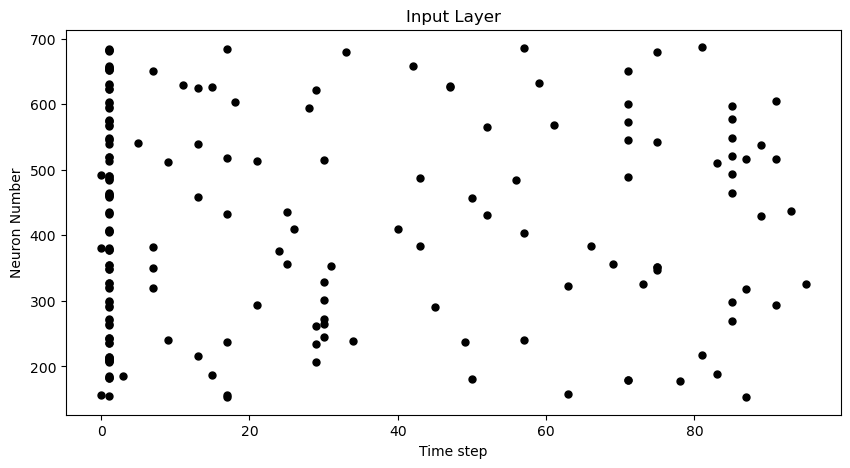

In [62]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [64]:
spike_data_sample = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

plt.close()
HTML(anim.to_html5_video())


The flash of the number observed is the initial frame where most of the spikes occur. 

In [65]:
print(targets_it[0])

tensor(8)


# Delta Modulation

Delta modulation is based on event-driven spiking. The `snntorch.delta` function accepts a time-series tensor as input. It takes the difference between each subsequent feature across all time steps. By default, if the difference is both positive and greater than the threshold $V_{thr}$, a spike is generated:

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_7_delta.png?raw=true" width="400">



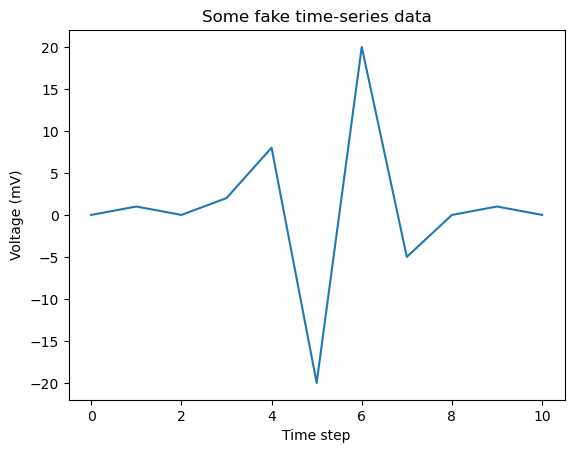

In [66]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

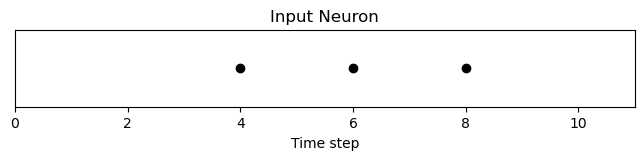

In [67]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

To detect off spikes, set `off_spike=True`. 

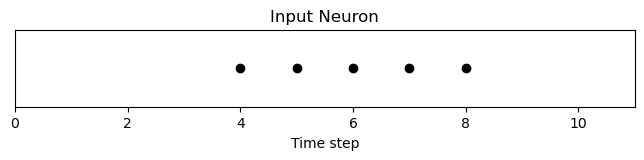

In [68]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

In [69]:
# -1 = off spike, +1 = on spike
print(spike_data)

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


**TL;DR Delta modulation might be the motive for time-series biosignal data** if all we care about are sufficiently large changes/events in the signal. 